# <img style="float: left; padding-right: 10px; width: 45px"> GEC AI HUB: Introduction to Data Science and Machine Learning



## Lab 3:  Gradient Boosting and BackPropagation -- Part 1

**GEC AI Hub**<br>
**Summer 2019**<br>
**Instructors:** Pavlos Protopapas<br>
**Lab Instructors:** Patrick Ohiomoba and Esteban Reyes<br>

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll continue our exploration of tree based models and ensembles in order to solve problems of classification and regression by learning about boosting and the Gradient Boosting Trees class of Algorithms.

By the end of this lab, you should:

- Be familiar with the mechanism of gradient boosting
- Be familiar with the `sklearn` implementations of Adaboost and Gradient Boosting Trees
- Be familiar with XGBoost
 

In [19]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.datasets import make_blobs

# models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# helpers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Ensembles of Estimators: Gradient Boosting

Last week we learned about the underlying notion of **bagging** -- that multiple overfitting estimators can be combined to reduce the effect of this overfitting. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.

Gradient Boosting is very state of the art algorithm. It has major connections to logistic regression, gradient descent in a functional space, and search in information space.

The idea behind boosting is that we will use a bunch of weak learners and fit sequentially. We fit the first learner on the signal of our data, the second learner on the first residual, the third on the second residual and so on. At each stage we upweight the places that our previous learner did badly on. First let us illustrate.  Let's use an artificial dataset that we generated from a previous lab.

In [13]:
from sklearn.tree import DecisionTreeRegressor
X1 = np.arange(0, 2*np.pi, 0.1)
y1 = np.sin(X1) + 0.1*np.random.normal(size=X1.shape[0])

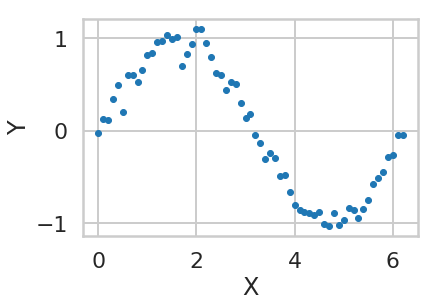

In [14]:
with sns.plotting_context('poster'):
    plt.plot(X1,y1, '.')
    plt.xlabel('X')
    plt.ylabel('Y');

**Exercise**:  Let's choose a weak learner to fit this data.  Choose Decision Trees with max-depth = 1 and 2 and fit them against our artificial dataset.  Create a plot overlaying the results of the fitted model on a scatter plot of the data

In [15]:
## Your code here

So it's clear that our weak learners don't do a great job of fitting the data.  These models have very little predictive power and severely underfit our data.  What happens if we create a random forest with our underfit models?

**Exercise**:  Create a random forest model that's an ensembler of Decision Trees with max-depth=1.  Fit this random forest model against our data and create a plot overlaying the results of the fitted model on a scatter plot of the data

In [11]:
## Your code here

**Key Insight** -- The Random Forest models as an ensemble aren't performing significantly better than the individual Decision Tree models upon which they're based.  The idea behind bagging based models is that the learners they're base are overfit, and we use bagging ensembles as a way to combat that.

### What happens if we use Gradient boosted Trees

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
estgb = GradientBoostingRegressor(n_estimators=500, max_depth=1, learning_rate=1.0)
estgb.fit(X1.reshape(-1,1), y1)
staged_predict_generator = estgb.staged_predict(X1.reshape(-1,1))

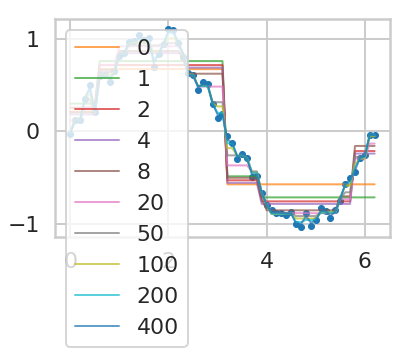

In [29]:
# code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
import time
from IPython import display
with sns.plotting_context('poster'):
    plt.plot(X1, y1, '.');
    i = 0 
    counter = 0
    for stagepred in staged_predict_generator:
        if i in [0, 1, 2, 4, 8, 20, 50, 100, 200, 400, 500]:
            plt.plot(X1, stagepred, alpha=0.7, label=str(i), lw=2)
            plt.legend();
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(2 - counter*0.1)
            counter = counter + 1
        i = i + 1

Ok, so this demonstration helps us understand some things about GBRT.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` to increase the bias.

YOUR TURN NOW

>Demonstrate what happens when you increase `max_depth` to 5

In [30]:
# your code here

YOUR TURN NOW

> What happens if you put `max_depth` back to 1 and decrease the learning rate to 0.1?

In [31]:
# your code here

### Whats the relationship between residuals and the gradient?

For the squared loss, taking the gradient in the "data point functional space", ie a N-d space for N data points with each variable being $f(x_i)$ just gives us the residuals. It turns out that the gradient descent is the more general idea, and one can use this for different losses. And the upweighting of poorly fit points in AdaBoost is simply a weighing by gradient. If the gradient (or residual) is high it means you are far away from optimum in this functional space, and if you are at 0, you have a flat gradient!

The ideas from the general theory of gradient descent tell us this: we can slow the learning by shrinking the predictions of each tree by some small number, which is called the learning_rate (learning_rate). This "shrinkage" helps us not overshoot, but for a finite number of iterations also simultaneously ensures we dont overfit by being in the neighboorhood of the minimum rather than just at it! But we might need to increase the iterations some to get into the minimum area.

## Dataset

First, the data. This one is built into sklearn, its a dataset about california housing prices. Its quite skewed as we shall see.

In [39]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()



In [40]:
cal_housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# split 80/20 train-test
Xtrain, Xtest, ytrain, ytest = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2)
names = cal_housing.feature_names

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde2fac0160>,
      dtype=object)

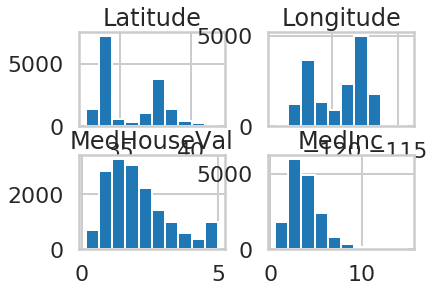

In [43]:
df = pd.DataFrame(data=Xtrain, columns=names)
df['MedHouseVal'] = ytrain
df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal'])

Notice the high bump in the median house value. why do you think that is? How might you model it?

In [44]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.3333,33.0,5.782828,0.994949,508.0,2.565657,36.78,-119.75,0.813
1,4.1573,19.0,6.162630,1.048443,1677.0,2.901384,34.63,-118.18,2.281
2,2.8452,24.0,6.096698,1.132075,1442.0,3.400943,35.40,-119.42,1.047
3,2.7679,18.0,6.135447,1.046110,815.0,2.348703,38.56,-121.37,1.180
4,5.3054,36.0,5.860390,0.935065,882.0,2.863636,33.96,-118.01,2.735


In [45]:
df.shape

(16512, 9)

### Ok, so how to do the fit?

In [46]:
gb = GradientBoostingRegressor(n_estimators=1000, max_depth=5)
gb.fit(Xtrain, ytrain)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

A deviance plot can be used to compare train and test errors against the number of iterations.

- Training error (deviance, related to the KL-divergence) is stored in `est.train_score_`
- Test error is computed using `est.staged_predict` (this uses `est.loss_`)

In [47]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

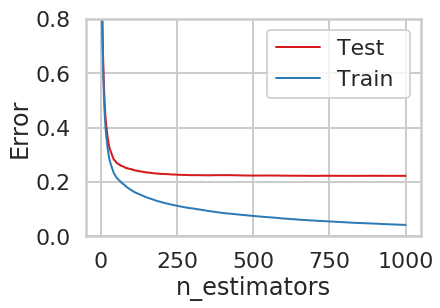

In [48]:
deviance_plot(gb, Xtest, ytest, ylim=(0,0.8));
plt.legend();

Notice the wide gap. This is an indication of overfitting!

Unlike random forests, where we are using the randomness to our benefits, the GBRT requires careful cross-validation

Peter Prettenhofer, who wrote sklearns GBRT implementation writes in his pydata14 talk (worth watching!)

>Hyperparameter tuning
I usually follow this recipe to tune the hyperparameters:

>- Pick n_estimators as large as (computationally) possible (e.g. 3000)
- Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search
- A lower learning_rate requires a higher number of n_estimators. Thus increase n_estimators even more and tune learning_rate again holding the other parameters fixed

This last point is a tradeof between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

Let me add however, that poor learners do rather well. So you might want to not cross-validate `max_depth`. And `min_samples_per_leaf` is not independent either, so if you do use cross-val, you might just use one of those.